In [3]:
# Importing required packages
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

In [4]:
# Defining function to convert the string tensor into a tensor with one-hot-encoded sequence
def onehotify(tensor):
  vocab = {'A':'1', 'C':'2', 'G':'3', 'T':'0'}
  for key in vocab.keys():
    tensor = tf.strings.regex_replace(tensor, key, vocab[key])
  split = tf.strings.bytes_split(tensor)
  labels = tf.cast(tf.strings.to_number(split), tf.uint8)
  onehot = tf.one_hot(labels, 4)
  onehot = tf.reshape(onehot, (-1,))
  return onehot

In [5]:
# Loading 'genomics_ood' dataset
# with 100000 samples of training examples
train_seg, train_label = tfds.as_numpy(tfds.load('genomics_ood', split='train[:10%]', batch_size=-1, as_supervised=True))

#and 1000 samples of test examples
test_seq, test_label = tfds.as_numpy(tfds.load('genomics_ood', split='test[:1%]', batch_size=-1, as_supervised=True))

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset genomics_ood downloaded and prepared to /root/tensorflow_datasets/genomics_ood/0.0.1. Subsequent calls will reuse this data.


In [6]:
# Preparing training sequences and their labels
gen_train_seq = tf.data.Dataset.from_tensor_slices(train_seg)
# Apply given above function on training sequences
gen_train_seq = gen_train_seq.map(onehotify)

gen_train_label = tf.data.Dataset.from_tensor_slices(train_label)
# Apply one-hot-encoding on training labels
gen_train_label = gen_train_label.map(lambda t: tf.one_hot(t, 10))

# Zipping together sequences and their labels
train_ds = tf.data.Dataset.zip((gen_train_seq, gen_train_label))
train_ds = train_ds.batch(128)
train_ds = train_ds.shuffle(buffer_size=128)

In [7]:
# Preparing testing sequences and their labels
gen_test_seq = tf.data.Dataset.from_tensor_slices(test_seq)
# Apply given above function on test sequences
gen_test_seq = gen_test_seq.map(onehotify)

gen_test_label = tf.data.Dataset.from_tensor_slices(test_label)
# Apply one-hot-encoding on test labels
gen_test_label = gen_test_label.map(lambda t: tf.one_hot(t, 10))

# Zipping together sequences and their labels
test_ds = tf.data.Dataset.zip((gen_test_seq, gen_test_label))
test_ds = test_ds.batch(128)
test_ds = test_ds.shuffle(buffer_size=128)

In [8]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

# Implementing fully connected feed forward neural network
class Model(Model): 
    
    def __init__(self):
        super(Model, self).__init__()
        # Define the hidden layer
        self.hidden_layer_1 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )
        self.hidden_layer_2 = tf.keras.layers.Dense(units=256,
                                               activation=tf.keras.activations.sigmoid
                                               )                              
        self.output_layer = tf.keras.layers.Dense(units=10, activation=tf.keras.activations.softmax, use_bias=False)
                                               
       
    def call(self, x):
        # Define the forward step.
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.output_layer(x)
        return x

In [9]:
def train_step(model, input, target, loss_function, optimizer):
  # loss_object and optimizer_object are instances of respective tensorflow classes
  with tf.GradientTape() as tape:
    prediction = model(input)
    loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))
  return loss 

def test(model, test_data, loss_function):
  # test over complete test data

  test_accuracy_aggregator = []
  test_loss_aggregator = []

  for (input, target) in test_data:
    prediction = model(input)
    sample_test_loss = loss_function(target, prediction)
    sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
    sample_test_accuracy = np.mean(sample_test_accuracy)
    test_loss_aggregator.append(sample_test_loss.numpy())
    test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

  test_loss = np.mean(test_loss_aggregator)
  test_accuracy = np.mean(test_accuracy_aggregator)

  return test_loss, test_accuracy
  

In [10]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.1
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. 
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

#testing once before we begin
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

#check how model performs on train data once before we begin
train_loss, _ = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_ds = train_ds.shuffle(buffer_size=128)
    test_ds = test_ds.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_ds:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)



Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9


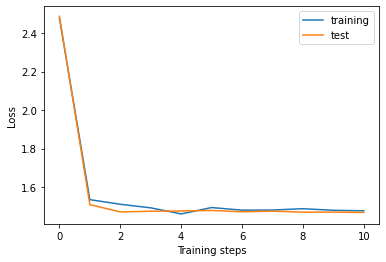

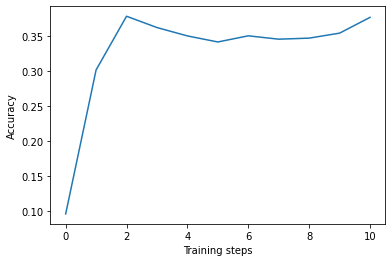

In [11]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()
